# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import math as mt
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import binom
import scipy.stats as stats
from statsmodels.stats import weightstats

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

import xgboost as xgb

import warnings

warnings.filterwarnings('ignore')

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

C:\Users\briodev\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [7]:
df = pd.read_csv("ABAdRecall.csv")

# Task 2.2 
# Machine Learning

## Feature Engineering

In [8]:
conditions = [
    (df['yes'] == 1) & (df['no'] == 0),
    (df['yes'] == 0) & (df['no'] == 1),
    (df['yes'] == 0) & (df['no'] == 0)
    
]

values = [1, 0, 2]

df['target_value'] = np.select(conditions, values)

In [9]:
conditons = [
    (df['hour'] >= 0 ) & (df['hour'] < 6),
    (df['hour'] >= 6 ) & (df['hour'] < 12),
    (df['hour'] >= 12 ) & (df['hour'] < 18),
    (df['hour'] >= 18 ) & (df['hour'] <= 23)
]

values = [0, 1, 2, 3]

df['day_part'] = np.select(conditons, values)

In [10]:
#df.drop(df.loc[df['target_value'] == 2].index, inplace=True)

In [11]:
df['target_value'].nunique()

3

## Feature Encoding

In [12]:
# Convert more variables to numeric
df["encoded_date"] = label_encoder.fit_transform(df["date"])
df["encoded_experiment"] = label_encoder.fit_transform(df["experiment"])
df["encoded_devicemake"] = label_encoder.fit_transform(df["device_make"])
df["encoded_browser"] = label_encoder.fit_transform(df["browser"])

In [13]:
# Dropping columns
ml_df = df.drop(['auction_id','yes','no','hour', 'experiment','date','device_make','browser'], 1)
ml_df.head()

,platform_os,target_value,day_part,encoded_date,encoded_experiment,encoded_devicemake,encoded_browser
0,6,2,1,7,1,46,2
1,6,2,1,4,1,46,2
2,6,0,0,2,1,29,3
3,6,2,2,0,0,137,6
4,6,2,2,0,0,46,2


In [14]:
# rearranging columns
ml_df = ml_df[['encoded_experiment', 'encoded_devicemake', 'encoded_browser', 'platform_os', 'encoded_date', 
               'day_part', 'target_value']]
ml_df.head()

,encoded_experiment,encoded_devicemake,encoded_browser,platform_os,encoded_date,day_part,target_value
0,1,46,2,6,7,1,2
1,1,46,2,6,4,1,2
2,1,29,3,6,2,0,0
3,0,137,6,6,0,2,2
4,0,46,2,6,0,2,2


### Splitting data into train and test sets

In [15]:
X = ml_df.loc[:, ml_df.columns != "target_value"]

y = ml_df[['target_value']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## KFold validation

### Helper functions

In [16]:
"""
function takes model, x_train and y_train parameters.
instantiate kfold and split the train set into 5 folds.
"""
def model_predictor(model, x, y):
    kf = KFold(n_splits = 5, random_state = 0, shuffle=True)
    for trainIndex, testIndex in kf.split(X_train):
        kfX_train, kfX_test = x.iloc[trainIndex], x.iloc[testIndex]
        kfy_train, kfy_test = y.iloc[trainIndex], y.iloc[testIndex]
        
        trained_model = model.fit(kfX_train, kfy_train)
    return trained_model

"""
function for computing evaluation scores. 
This include loss function which is computed by mean_squared_error
"""
def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    
    print("Loss function: {}".format(rmse))
    print("R2_Squared: {}".format(r_sq))
    print("MAE Score: {}".format(mae))
    
"""
Function that plots prediction vs original values for the algorithms.
"""
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='purple')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Conversion')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    #plt.savefig("ml_predict.png")
    plt.show()

## Instantiating models

In [17]:
xClassifier = xgb.XGBClassifier()
lReg = LogisticRegression()
dTree = DecisionTreeClassifier(criterion="entropy", max_depth=3)

## Logistic Regression

In [18]:
lRegTrained = model_predictor(lReg, X_train, y_train)

In [19]:
y_test.shape

(808, 1)

In [20]:
lRegTrained.score(X_test, y_test)

0.8725247524752475

In [21]:
lReg_kf_preds = lRegTrained.predict(X_test)

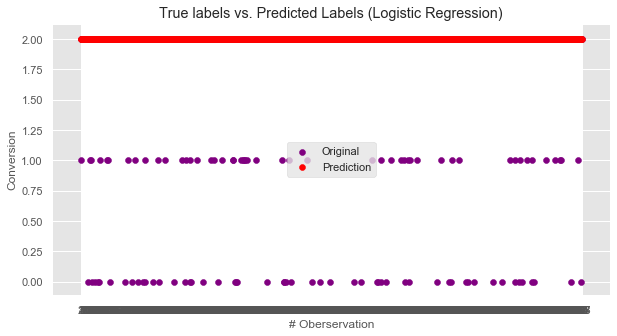

In [22]:
plot_preds(y_test, lReg_kf_preds, "Logistic Regression")

In [23]:
calculate_metrics(y_test, lReg_kf_preds)

Loss function: 0.5694360593978698
R2_Squared: -0.1298889837745516
MAE Score: 0.19306930693069307


Feature: 0, Score:0.10927
Feature: 1, Score:-0.00253
Feature: 2, Score:0.03774
Feature: 3, Score:-0.07498
Feature: 4, Score:-0.03378
Feature: 5, Score:-0.02596


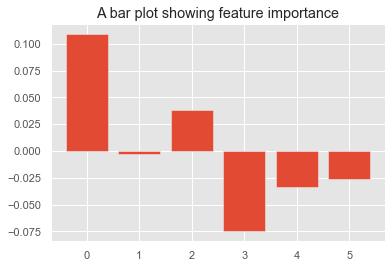

In [24]:
# get importance
importance = lRegTrained.coef_[0]

#summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score:%.5f' % (i,v))
    
# plot feature importance
plt.title('A bar plot showing feature importance')
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Decision Tree Classifier

In [25]:
dTreeTrained = model_predictor(dTree, X_train, y_train)

In [26]:
dTreeTrained.score(X_test, y_test)

0.8725247524752475

In [27]:
dtc_kf_preds = dTreeTrained.predict(X_test)

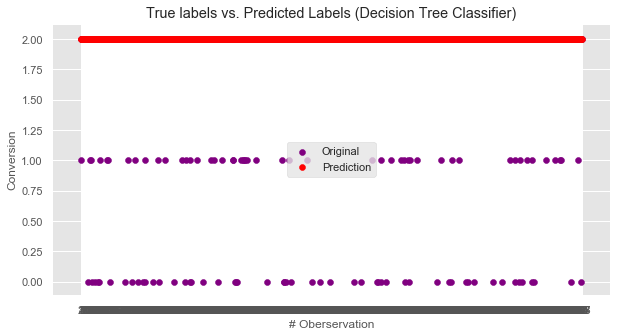

In [28]:
plot_preds(y_test, dtc_kf_preds, "Decision Tree Classifier")

In [48]:
calculate_metrics(y_test, dtc_kf_preds)

Loss function: 0.644980619863884
R2_Squared: -0.7033542976939202
MAE Score: 0.416


In [29]:
importance_tree = dTreeTrained.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_tree):
    print('Feature: %0d, Score:%.5f' %(i,v))

Feature: 0, Score:0.13836
Feature: 1, Score:0.66786
Feature: 2, Score:0.09676
Feature: 3, Score:0.00000
Feature: 4, Score:0.03680
Feature: 5, Score:0.06021


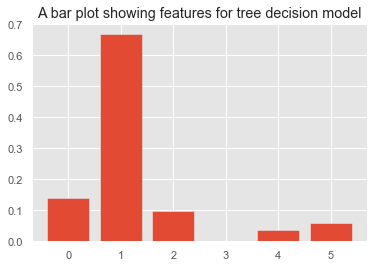

In [32]:
# plot feature importance
plt.title('A bar plot showing features for tree decision model')
plt.bar([x for x in range(len(importance_tree))], importance_tree)
#plt.savefig('feature_importance.png')
plt.show()

### Decision tree visualization

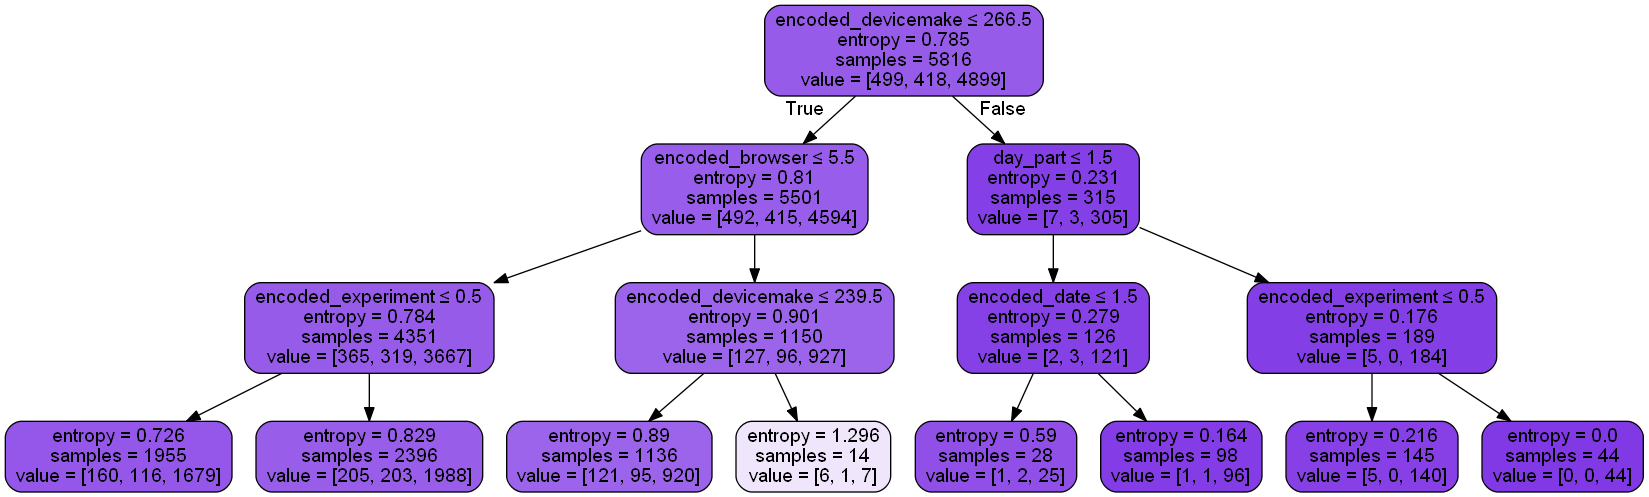

In [35]:
dot_data = StringIO()
export_graphviz(dTreeTrained, out_file=dot_data,
               filled=True, rounded=True,
               special_characters=True,
               feature_names=X_train.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('decision_tree.png')
Image(graph.create_png())

## xGBoost model

In [50]:
xClassifierTrained = model_predictor(xClassifier, X_train, y_train)
#lRegTrained, lrScores = model_predictor(lReg, X_train, y_train)
#dTreeTrained, dtScores = model_predictor(dTree, X_train, y_train)

In [51]:
xClassifierTrained.score(X_test, y_test)

0.8675742574257426

In [52]:
xgb_kf_preds = xClassifierTrained.predict(X_test)

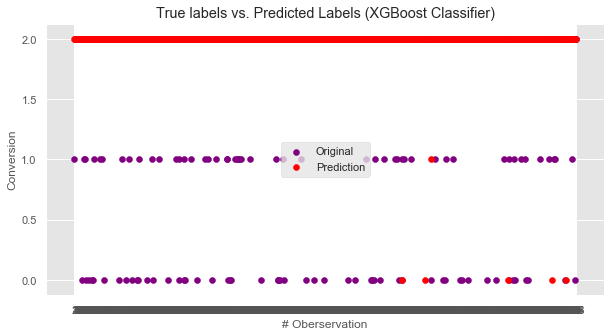

In [53]:
plot_preds(y_test, xgb_kf_preds, "XGBoost Classifier")

In [53]:
calculate_metrics(y_test, xgb_kf_preds)

Loss function: 0.6572670690061994
R2_Squared: -0.7688679245283017
MAE Score: 0.432
